**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [61]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
dt_clf = DecisionTreeClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Define parameter grids (matching pipeline step names)
param_grid_dt = {
    'feature_selection__k': [5, 10, 15],  # Optional: include feature selection tuning
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10]
}

param_grid_knn = {
    'feature_selection__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

param_grid_lr = {
    'feature_selection__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# Create list of (classifier instance, param grid, name) tuples
classifiers_to_tune = [
    (dt_clf, param_grid_dt, 'Decision Tree'),
    (knn_clf, param_grid_knn, 'kNN'),
    (lr_clf, param_grid_lr, 'Logistic Regression')
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [63]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [64]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [65]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [66]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [67]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # Adjust 'k' for feature selection
        adjusted_grid = {
            param: [v for v in values if v <= n_features] if param == 'feature_selection__k' else values
            for param, values in param_grid.items()
        }

        keys, values = zip(*adjusted_grid.items())
        param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

        for params in param_combinations:
            fold_scores = []

            for train_idx, val_idx in cv.split(X_train, y_train):
                X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(score_func=f_classif)),
                    ('classifier', clone(classifier_instance))
                ])
                pipeline.set_params(**params)
                pipeline.fit(X_fold_train, y_fold_train)
                y_prob = pipeline.predict_proba(X_fold_val)[:, 1]
                auc = roc_auc_score(y_fold_val, y_prob)
                fold_scores.append(auc)

            mean_auc = np.mean(fold_scores)
            print(f"Params: {params} | Mean AUC: {mean_auc:.4f}")

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params

        print("-" * 90)
        print(f"✅ Best parameters for {name}: {best_params}")
        print(f"📈 Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif)),
            ('classifier', clone(classifier_instance))
        ])
        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)
        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # Adjust feature selection parameter grid based on dataset size
        adjusted_param_grid = {
            'feature_selection__k': [int(n_features * 0.25), int(n_features * 0.5), 'all']
        }

        # Add classifier-specific parameters
        for param, values in param_grid.items():
            adjusted_param_grid[param] = values

        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(score_func=f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set up cross-validation
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Run GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            cv=cv_splitter,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )

        try:
            grid_search.fit(X_train, y_train)
            results_builtin[name] = {
                'best_estimator': grid_search.best_estimator_,
                'best_score (CV)': grid_search.best_score_,
                'best_params': grid_search.best_params_
            }

            print(f"Best params for {name}: {results_builtin[name]['best_params']}")
            print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")
        except Exception as e:
            print(f"Error processing {name}: {e}")
            continue

    return results_builtin


## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [69]:
def evaluate_models(X_test, y_test, best_estimators, dataset_name, method_name="Manual",X_train=None, y_train=None):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [70]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_test, y_test, manual_estimators, actual_name, "Manual")

     


    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator'] for name, results in builtin_results.items()}

    # Pass X_train and y_train here
    builtin_votes, builtin_proba = evaluate_models(
    X_test, y_test, builtin_estimators, actual_name, "Built-in", X_train=X_train, y_train=y_train
)
     

     
    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION

--- Manual Grid Search for Decision Tree ---
Params: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2} | Mean AUC: 0.7152
Params: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5} | Mean AUC: 0.7152
Params: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 10} | Mean AUC: 0.7145
Params: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2} | Mean AUC: 0.7087


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5} | Mean AUC: 0.7082
Params: {'feature_selection__k': 5, 'classifier__max_depth': 5, 'classifier__min_samples_split': 10} | Mean AUC: 0.7067
Params: {'feature_selection__k': 5, 'classifier__max_depth': 10, 'classifier__min_samples_split': 2} | Mean AUC: 0.6261
Params: {'feature_selection__k': 5, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5} | Mean AUC: 0.6497
Params: {'feature_selection__k': 5, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10} | Mean AUC: 0.6601


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 5, 'classifier__max_depth': None, 'classifier__min_samples_split': 2} | Mean AUC: 0.6071
Params: {'feature_selection__k': 5, 'classifier__max_depth': None, 'classifier__min_samples_split': 5} | Mean AUC: 0.6133
Params: {'feature_selection__k': 5, 'classifier__max_depth': None, 'classifier__min_samples_split': 10} | Mean AUC: 0.6450
Params: {'feature_selection__k': 10, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2} | Mean AUC: 0.7082


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5} | Mean AUC: 0.7082
Params: {'feature_selection__k': 10, 'classifier__max_depth': 3, 'classifier__min_samples_split': 10} | Mean AUC: 0.7082
Params: {'feature_selection__k': 10, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2} | Mean AUC: 0.7021
Params: {'feature_selection__k': 10, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5} | Mean AUC: 0.6961
Params: {'feature_selection__k': 10, 'classifier__max_depth': 5, 'classifier__min_samples_split': 10} | Mean AUC: 0.7001


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__max_depth': 10, 'classifier__min_samples_split': 2} | Mean AUC: 0.6099
Params: {'feature_selection__k': 10, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5} | Mean AUC: 0.6353
Params: {'feature_selection__k': 10, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10} | Mean AUC: 0.6547
Params: {'feature_selection__k': 10, 'classifier__max_depth': None, 'classifier__min_samples_split': 2} | Mean AUC: 0.6334


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__max_depth': None, 'classifier__min_samples_split': 5} | Mean AUC: 0.6348
Params: {'feature_selection__k': 10, 'classifier__max_depth': None, 'classifier__min_samples_split': 10} | Mean AUC: 0.6496
Params: {'feature_selection__k': 15, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2} | Mean AUC: 0.7076
Params: {'feature_selection__k': 15, 'classifier__max_depth': 3, 'classifier__min_samples_split': 5} | Mean AUC: 0.7076
Params: {'feature_selection__k': 15, 'classifier__max_depth': 3, 'classifier__min_samples_split': 10} | Mean AUC: 0.7076
Params: {'feature_selection__k': 15, 'classifier__max_depth': 5, 'classifier__min_samples_split': 2} | Mean AUC: 0.6892
Params: {'feature_selection__k': 15, 'classifier__max_depth': 5, 'classifier__min_samples_split': 5} | Mean AUC: 0.6883
Params: {'feature_selection__k': 15, 'classifier__max_depth': 5, 'classifier__min_samples_split': 10} | Mean AUC: 0.6922


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 15, 'classifier__max_depth': 10, 'classifier__min_samples_split': 2} | Mean AUC: 0.6055
Params: {'feature_selection__k': 15, 'classifier__max_depth': 10, 'classifier__min_samples_split': 5} | Mean AUC: 0.6200
Params: {'feature_selection__k': 15, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10} | Mean AUC: 0.6577
Params: {'feature_selection__k': 15, 'classifier__max_depth': None, 'classifier__min_samples_split': 2} | Mean AUC: 0.5986


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 15, 'classifier__max_depth': None, 'classifier__min_samples_split': 5} | Mean AUC: 0.6261
Params: {'feature_selection__k': 15, 'classifier__max_depth': None, 'classifier__min_samples_split': 10} | Mean AUC: 0.6553
------------------------------------------------------------------------------------------
✅ Best parameters for Decision Tree: {'feature_selection__k': 5, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
📈 Best cross-validation AUC: 0.7152

--- Manual Grid Search for kNN ---
Params: {'feature_selection__k': 5, 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'} | Mean AUC: 0.6578
Params: {'feature_selection__k': 5, 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'} | Mean AUC: 0.6474
Params: {'feature_selection__k': 5, 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'} | Mean AUC: 0.6696
Params: {'feature_selection__k': 5, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'} | 

C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'} | Mean AUC: 0.6716
Params: {'feature_selection__k': 10, 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'} | Mean AUC: 0.6974
Params: {'feature_selection__k': 10, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'} | Mean AUC: 0.6978
Params: {'feature_selection__k': 10, 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'} | Mean AUC: 0.7002


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'} | Mean AUC: 0.7073
Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'} | Mean AUC: 0.6748
Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 3, 'classifier__weights': 'distance'} | Mean AUC: 0.6711
Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'} | Mean AUC: 0.6876


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 5, 'classifier__weights': 'distance'} | Mean AUC: 0.6878
Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'} | Mean AUC: 0.6840
Params: {'feature_selection__k': 15, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'} | Mean AUC: 0.6873
------------------------------------------------------------------------------------------
✅ Best parameters for kNN: {'feature_selection__k': 10, 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
📈 Best cross-validation AUC: 0.7073

--- Manual Grid Search for Logistic Regression ---
Params: {'feature_selection__k': 5, 'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7312


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 5, 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7314
Params: {'feature_selection__k': 5, 'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7312
Params: {'feature_selection__k': 5, 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7309
Params: {'feature_selection__k': 10, 'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7516
Params: {'feature_selection__k': 10, 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7529


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 10, 'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7528
Params: {'feature_selection__k': 10, 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7527
Params: {'feature_selection__k': 15, 'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7759
Params: {'feature_selection__k': 15, 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7776


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Params: {'feature_selection__k': 15, 'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7745
Params: {'feature_selection__k': 15, 'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} | Mean AUC: 0.7739
------------------------------------------------------------------------------------------
✅ Best parameters for Logistic Regression: {'feature_selection__k': 15, 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
📈 Best cross-validation AUC: 0.7776

EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8231
  Precision: 0.3333
  Recall: 0.0986
  F1-Score: 0.1522
  ROC AUC: 0.7107

kNN:
  Accuracy: 0.8186
  Precision: 0.3953
  Recall: 0.2394
  F1-Score: 0.2982
  ROC AUC: 0.7130

Logistic Regression:
  Accuracy: 0.8571
  Precision: 0.6333
  Recall: 0.2676
  F1-Score: 0.3762
  ROC AUC: 0.7762

--- Manual Voting Classifier ---
Voting C

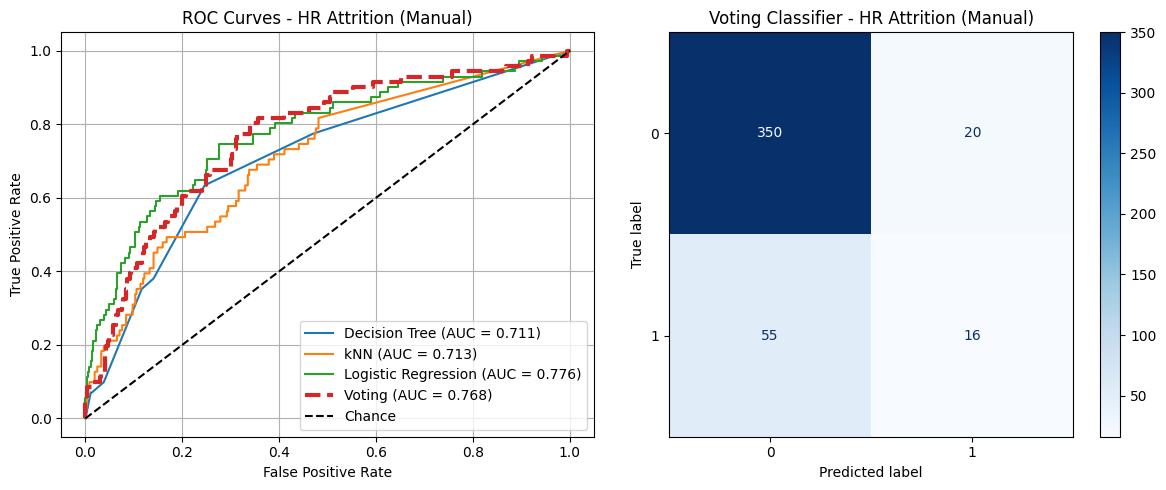


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best params for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'feature_selection__k': 15}
Best CV score: 0.8542

--- GridSearchCV for kNN ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params for kNN: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'feature_selection__k': 10}
Best CV score: 0.8571

--- GridSearchCV for Logistic Regression ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 4 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\raksh\AppData\Roaming\Python\Python312\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features 

Best params for Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'feature_selection__k': 15}
Best CV score: 0.8639

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8322
  Precision: 0.4571
  Recall: 0.2254
  F1-Score: 0.3019
  ROC AUC: 0.7331

kNN:
  Accuracy: 0.8186
  Precision: 0.3953
  Recall: 0.2394
  F1-Score: 0.2982
  ROC AUC: 0.7130

Logistic Regression:
  Accuracy: 0.8571
  Precision: 0.6333
  Recall: 0.2676
  F1-Score: 0.3762
  ROC AUC: 0.7762

--- Built-in Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.8322, Precision: 0.4444
  Recall: 0.1690, F1: 0.2449, AUC: 0.7805


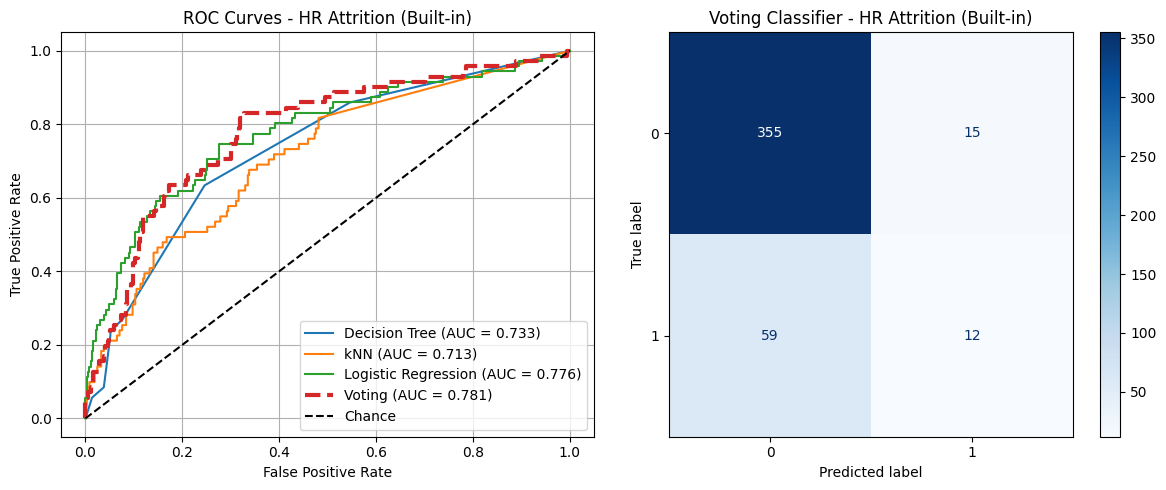


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [71]:
datasets = [
    (load_hr_attrition, "HR Attrition")
]

for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)
